In [1]:
import numpy as np
import pandas as pd
import fastparquet
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string

In [2]:
#Data pre processing: ....copied from before
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')
advances = pd.read_parquet("data_science_take_home_advances.parquet", engine='pyarrow')

###1. Convert 'account_id' to numerical values
# Create a copy of the 'account_id' column as 'account_id_string'
transactions['account_id_string'] = transactions['account_id'].copy()
advances['account_id_string'] = advances['account_id'].copy()

label_encoder = LabelEncoder() # Create a label encoder object

transactions['account_id'] = label_encoder.fit_transform(transactions['account_id']) # Transform 'account_id' column to numerical values and replace the original column 
advances['account_id'] = label_encoder.fit_transform(advances['account_id'])


###3. Lets ignore irrelevant columns: 

columns_to_remove = ['version', 'currency_code', 'pending', 'removed', 'selected_data', 'city', 'region', 'payment_meta_payment_processor',
                    'authorized_date', 'payment_meta_payment_method', 'payment_channel']
cleaned_data = selected_data.drop(columns=columns_to_remove, axis=1, errors='ignore')

# Let's ensure the 'date' column is converted to a datetime format before using the .dt accessor. 
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Feature Engineering: Extract features from dates and descriptions
cleaned_data['day_of_week'] = cleaned_data['date'].dt.dayofweek
cleaned_data['week_number'] = cleaned_data['date'].dt.isocalendar().week
cleaned_data['month'] = cleaned_data['date'].dt.month

cleaned_data

,account_id,id,f0_,date,name,bank_account_id,account_id_string,day_of_week,week_number,month
2,1665,nnrDNrPjA4ioerJ0qXd8udLnrNznJes7zYNwO,-3.00,2021-11-22,"NONTD ATM FEE, NONTD ATM FE",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,0,47,11
4,1665,bQjKpjODw8cLVEZB6kD9fez4dN04ZQs9nVoz0,54.18,2021-11-24,"VISA TRANSFER, *****30100057355, AUT 112321 VI...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,47,11
8,1665,Ey4Jp46mdbFg1DeKAZ5mSXrqmXELO1hExe88P,-22.00,2022-06-22,"NONTD ATM DEBIT, *****30100057355, AUT 062222 ...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,25,6
11,1665,Q87Qp7vXkJTxJjQZb97NtaMyELjyQDTJ85MxQ,200.00,2021-11-10,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,45,11
13,1665,5mNEXNZyn3SRbZ3mY4ejhJwQ1Jrj3MhVv71RM,-0.64,2022-07-05,"INTL TXN FEE, INTL TXN FE",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,1,27,7
...,...,...,...,...,...,...,...,...,...,...
1962474,1201,4pne03LZwphYQDoBPNOySXj5AVeB8VC1vAw40,92.00,2022-10-21,Zayzoon Payout CHEYENNE WY 125560 10/2,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,42,10
1962475,1201,Jz1BNvo4Lzij8J6QMdkri5kYZLx0aLIAe9jno,94.00,2022-09-02,Zayzoon Payout CHEYENNE WY 153665 09/0,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,35,9
1962476,1201,XzXPRnNowziV9LMxp308H56PqVoxyVIO3rRZq,94.00,2022-09-30,Zayzoon Payout CHEYENNE WY 207757 09/3,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,39,9
1962477,1201,6pe4EK17LphMrwY67NQ0uoM90xJOXxiV40P84,84.00,2022-12-02,Zayzoon Payout CHEYENNE WY 455830 12/0,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,48,12


# Lets analyze distinct accounts to try and predict if they qualify for a loan based on f0_ and dates. 

## Lets look at: account balance, income stability, spending habits and frequency of transactions...

## Lets start by plotting positive f0_ (deposits) and negative f0_ (withdrawls) per month and per week.

In [3]:
#account_ids = [1665, 213, 736, 1633, 141]

# Filter transactions for the specified account_id
account_data = cleaned_data[cleaned_data['account_id'] ==213]

In [4]:
print("Minimum date:", account_data['date'].min())
print("Maximum date:", account_data['date'].max())
from dateutil.relativedelta import relativedelta
total_time_span = relativedelta(account_data['date'].max(), account_data['date'].min())
total_months = total_time_span.years * 12 + total_time_span.months
print("Total time span:", total_months, "months")

Minimum date: 2022-06-14 00:00:00
Maximum date: 2023-01-05 00:00:00
Total time span: 6 months


# (1) account balance binned in time - first by month and then by week.

Number of months where withdrawals exceed deposits: 3
Average amount by which withdrawals exceed deposits: 79.33333333333333
Percentage of months where withdrawals exceed deposits: 37.5


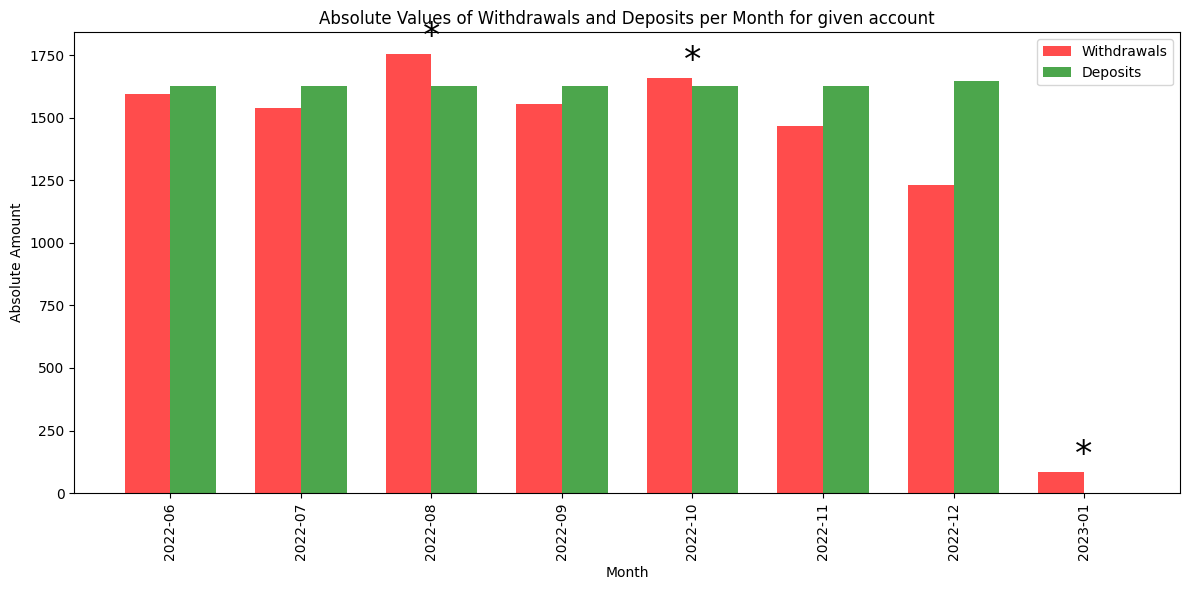

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'account_data' is your DataFrame containing the transactional data

# Separate withdrawals and deposits
withdrawals = account_data[account_data['f0_'] < 0]['f0_'].abs()
deposits = account_data[account_data['f0_'] > 0]['f0_'].abs()

# Group the data by month and calculate the sum of absolute values of withdrawals and deposits
withdrawals_monthly = withdrawals.groupby(account_data['date'].dt.to_period('M')).sum()
deposits_monthly = deposits.groupby(account_data['date'].dt.to_period('M')).sum()

# Align the two DataFrames on the index
withdrawals_monthly, deposits_monthly = withdrawals_monthly.align(deposits_monthly, fill_value=0)

# Create positions for the bars
months = withdrawals_monthly.index.astype(str)
bar_width = 0.35
index = np.arange(len(months))

# Plot a histogram for absolute values of withdrawals and deposits
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visualization

# Plot absolute values of withdrawals
ax.bar(index, withdrawals_monthly, width=bar_width, color='red', alpha=0.7, label='Withdrawals')
# Plot absolute values of deposits next to withdrawals
ax.bar(index + bar_width, deposits_monthly, width=bar_width, color='green', alpha=0.7, label='Deposits')

# Calculate the difference between withdrawals and deposits for each month where withdrawals exceed deposits
excess_differences = (withdrawals_monthly - deposits_monthly)[withdrawals_monthly > deposits_monthly]

# Print the number of months where withdrawals exceed deposits
num_exceeding_months = np.sum(withdrawals_monthly > deposits_monthly)
print("Number of months where withdrawals exceed deposits:", num_exceeding_months)

# Print the average amount by which withdrawals exceed deposits
average_excess = excess_differences.mean()
print("Average amount by which withdrawals exceed deposits:", average_excess)

total_months = len(withdrawals_monthly)
percent_exceeding_months = (num_exceeding_months / total_months) * 100
print("Percentage of months where withdrawals exceed deposits:", percent_exceeding_months)


# Add a symbol on months where withdrawals exceed deposits
for i, (withdrawal, deposit) in enumerate(zip(withdrawals_monthly, deposits_monthly)):
    if withdrawal > deposit:
        ax.text(i + bar_width / 2, max(withdrawal, deposit), '*', ha='center', va='bottom', color='black', fontsize=25)

# Customize the plot
ax.set_title('Absolute Values of Withdrawals and Deposits per Month for given account')
ax.set_xlabel('Month')
ax.set_ylabel('Absolute Amount')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(months, rotation=90)  # Rotate x-axis tick labels by 90 degrees for readability

# Add a label in the legend for "Withdrawals exceed Deposits"
ax.legend(['Withdrawals', 'Deposits', 'Withdrawals > Deposits'])

plt.tight_layout()
plt.show()



Number of weeks where withdrawals exceed deposits: 8
Average amount by which withdrawals exceed deposits: 81.75
Percentage of weeks where withdrawals exceed deposits: 57.14285714285714


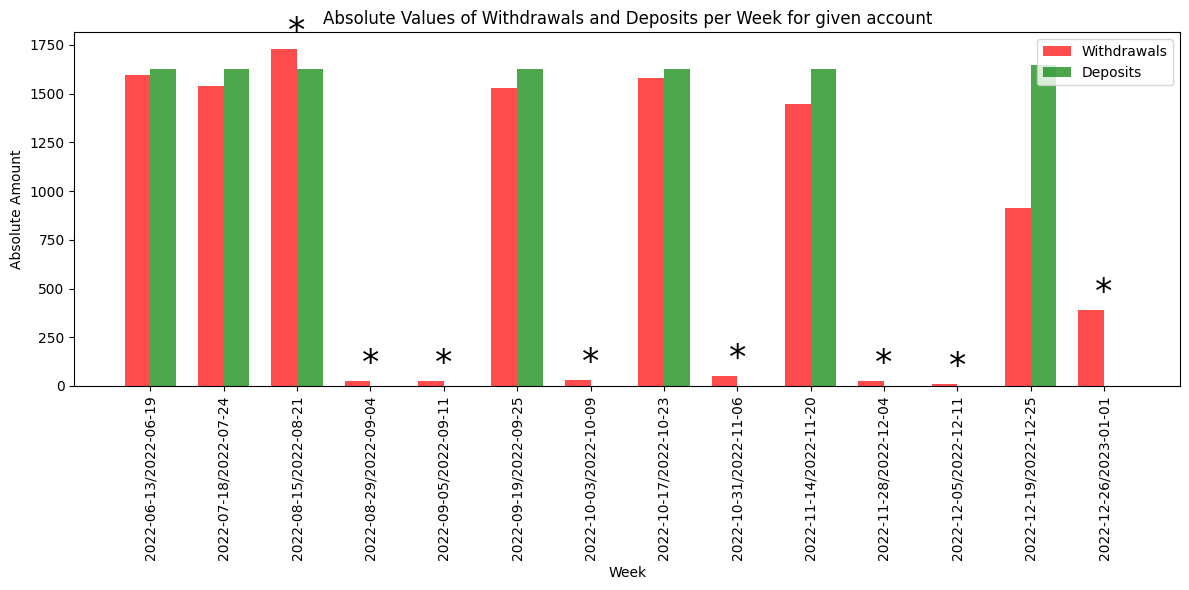

In [6]:
# Separate withdrawals and deposits
withdrawals = account_data[account_data['f0_'] < 0]['f0_'].abs()
deposits = account_data[account_data['f0_'] > 0]['f0_'].abs()

# Group the data by week and calculate the sum of absolute values of withdrawals and deposits
withdrawals_weekly = withdrawals.groupby(account_data['date'].dt.to_period('W')).sum()
deposits_weekly = deposits.groupby(account_data['date'].dt.to_period('W')).sum()

# Align the two DataFrames on the index
withdrawals_weekly, deposits_weekly = withdrawals_weekly.align(deposits_weekly, fill_value=0)

# Create positions for the bars
weeks = withdrawals_weekly.index.astype(str)
bar_width = 0.35
index = np.arange(len(weeks))

# Plot a histogram for absolute values of withdrawals and deposits
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visualization

# Plot absolute values of withdrawals
ax.bar(index, withdrawals_weekly, width=bar_width, color='red', alpha=0.7, label='Withdrawals')
# Plot absolute values of deposits next to withdrawals
ax.bar(index + bar_width, deposits_weekly, width=bar_width, color='green', alpha=0.7, label='Deposits')

# Calculate the difference between withdrawals and deposits for each week where withdrawals exceed deposits
excess_differences = (withdrawals_weekly - deposits_weekly)[withdrawals_weekly > deposits_weekly]

# Print the average amount by which withdrawals exceed deposits
num_exceeding_weeks = np.sum(withdrawals_weekly > deposits_weekly)
print("Number of weeks where withdrawals exceed deposits:", num_exceeding_weeks)

average_excess = excess_differences.mean()
print("Average amount by which withdrawals exceed deposits:", average_excess)

# Print the percentage of weeks where withdrawals exceed deposits
total_weeks = len(withdrawals_weekly)
percent_exceeding_weeks = (num_exceeding_weeks / total_weeks) * 100
print("Percentage of weeks where withdrawals exceed deposits:", percent_exceeding_weeks)



# Add a symbol on weeks where withdrawals exceed deposits
for i, (withdrawal, deposit) in enumerate(zip(withdrawals_weekly, deposits_weekly)):
    if withdrawal > deposit:
        ax.text(i + bar_width / 2, max(withdrawal, deposit), '*', ha='center', va='bottom', color='black', fontsize=25)

# Customize the plot
ax.set_title('Absolute Values of Withdrawals and Deposits per Week for given account')
ax.set_xlabel('Week')
ax.set_ylabel('Absolute Amount')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(weeks, rotation=90)  # Rotate x-axis tick labels by 90 degrees for readability

# Add a label in the legend for "Withdrawals exceed Deposits"
ax.legend(['Withdrawals', 'Deposits', 'Withdrawals > Deposits'])

plt.tight_layout()
plt.show()

In [7]:
# Group the data by week and calculate the sum of f0_ values for each week
weekly_net_f0 = account_data.groupby(account_data['date'].dt.to_period('W'))['f0_'].sum()

# Filter the weeks where the net f0_ value is negative
negative_weeks = weekly_net_f0[weekly_net_f0 < 0]

# Print the dates corresponding to the negative net f0_ weeks
print("Weeks with withdrawls > deposit")
for week_start_date in negative_weeks.index.to_timestamp():
    week_end_date = week_start_date + pd.DateOffset(days=6)  # Assuming weeks end on Sunday
    print("Week:", week_start_date.strftime('%Y-%m-%d'), "-", week_end_date.strftime('%Y-%m-%d'))

Weeks with withdrawls > deposit
Week: 2022-08-15 - 2022-08-21
Week: 2022-08-29 - 2022-09-04
Week: 2022-09-05 - 2022-09-11
Week: 2022-10-03 - 2022-10-09
Week: 2022-10-31 - 2022-11-06
Week: 2022-11-28 - 2022-12-04
Week: 2022-12-05 - 2022-12-11
Week: 2022-12-26 - 2023-01-01


## We may also look some averages.. if we notice red flags

In [13]:
# Identify income transactions (assuming credits represent income)
income_transactions = account_data[account_data['f0_'] > 0]

# Calculate average monthly income
total_income = income_transactions['f0_'].sum()
num_months = len(income_transactions['date'].dt.to_period('M').unique())
average_monthly_income = total_income / num_months

# Calculate standard deviation of income amounts
income_std_dev = income_transactions['f0_'].std()
# Calculate frequency of income deposits (assuming monthly frequency)
num_income_deposits = len(income_transactions)
num_months = len(income_transactions['date'].dt.to_period('M').unique())
income_frequency = num_income_deposits / num_months


expense_transactions = account_transactions[account_transactions['f0_'] < 0]
total_expenses = expense_transactions['f0_'].sum()

# Print results
print("Average Monthly Income:", average_monthly_income)
print("Standard Deviation of Income Amounts:", income_std_dev)
print("Frequency of Income Deposits (per month):", income_frequency)

# Compare income to expenses
if total_income > abs(total_expenses):
    print("Income exceeds expenses by:", total_income - abs(total_expenses))
elif total_income < abs(total_expenses):
    print("Expenses exceed income by:", abs(total_expenses) - total_income)
else:
    print("Income equals expenses")

NameError: name 'account_transactions' is not defined

In [14]:
cleaned_data

,account_id,id,f0_,date,name,bank_account_id,account_id_string,day_of_week,week_number,month,month_year,week_year
2,1665,nnrDNrPjA4ioerJ0qXd8udLnrNznJes7zYNwO,-3.00,2021-11-22,"NONTD ATM FEE, NONTD ATM FE",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,0,47,11,2021-11,47
4,1665,bQjKpjODw8cLVEZB6kD9fez4dN04ZQs9nVoz0,54.18,2021-11-24,"VISA TRANSFER, *****30100057355, AUT 112321 VI...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,47,11,2021-11,47
8,1665,Ey4Jp46mdbFg1DeKAZ5mSXrqmXELO1hExe88P,-22.00,2022-06-22,"NONTD ATM DEBIT, *****30100057355, AUT 062222 ...",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,25,6,2022-06,25
11,1665,Q87Qp7vXkJTxJjQZb97NtaMyELjyQDTJ85MxQ,200.00,2021-11-10,"ATM CASH DEPOSIT, *****3010005735",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,2,45,11,2021-11,45
13,1665,5mNEXNZyn3SRbZ3mY4ejhJwQ1Jrj3MhVv71RM,-0.64,2022-07-05,"INTL TXN FEE, INTL TXN FE",00kEXk41nDi5v4yjokE7TqDA4jxAeVhdDYMKz,w4d61f7p31574,1,27,7,2022-07,27
...,...,...,...,...,...,...,...,...,...,...,...,...
1962474,1201,4pne03LZwphYQDoBPNOySXj5AVeB8VC1vAw40,92.00,2022-10-21,Zayzoon Payout CHEYENNE WY 125560 10/2,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,42,10,2022-10,42
1962475,1201,Jz1BNvo4Lzij8J6QMdkri5kYZLx0aLIAe9jno,94.00,2022-09-02,Zayzoon Payout CHEYENNE WY 153665 09/0,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,35,9,2022-09,35
1962476,1201,XzXPRnNowziV9LMxp308H56PqVoxyVIO3rRZq,94.00,2022-09-30,Zayzoon Payout CHEYENNE WY 207757 09/3,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,39,9,2022-09,39
1962477,1201,6pe4EK17LphMrwY67NQ0uoM90xJOXxiV40P84,84.00,2022-12-02,Zayzoon Payout CHEYENNE WY 455830 12/0,Dzx6EBa4mziyMXKjV0ZxSngk5QNXJzHgx9jZK,kv8gyng97yyg2,4,48,12,2022-12,48


# Observations:
## - Account 1665: balance seems to be stable making this person eligble for a loan. no red flags

## - Accont 213: this account seems to have "unhealty" spending habbits. Red flags in terms of Percentage of weeks where withdrawals exceed deposits: 57%

## - Account 736 - looks stable on monthly basis but not weekly.

## - Account 1633 - stable


## Add month to week ratio? Averge monthly income-to-income exceeds expenses by-ratio...

## if  (Weeks with withdrawls > deposit) >> (Months with withdrawls > deposit) it probalby just means that they are paid on a monthey basis

### Might want to ignore outliers? (For ex: A one time large deposit may misrepresent account holders overall average) 

### Add minimum data requered (say 6 months old account?)



# Feature Engineering: Create features that represent financial behavior, such as average monthly balance, frequency of deposits, total amount of withdrawals, etc.


In [15]:
# Lets create:ID, account age, Average weekly balance, Average montly balance

In [42]:
import pandas as pd

# Assuming cleaned_data is your existing DataFrame with transaction data
# Let's assume 'date' column is already in datetime format

# Calculate daily balances
daily_balances = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.date])['f0_'].sum().reset_index()
daily_balances['date'] = pd.to_datetime(daily_balances['date'])  # Ensure date is datetime type

# Calculate average daily balance per account_id
average_daily_balance = daily_balances.groupby('account_id')['f0_'].mean().reset_index()
average_daily_balance.rename(columns={'f0_': 'avg_daily_balance'}, inplace=True)

# Calculate weekly balances
weekly_balances = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()

# Calculate average weekly balance per account_id
average_weekly_balance = weekly_balances.groupby('account_id')['f0_'].mean().reset_index()
average_weekly_balance.rename(columns={'f0_': 'avg_weekly_balance'}, inplace=True)

# Calculate monthly balances
monthly_balances = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()

# Calculate average monthly balance per account_id
average_monthly_balance = monthly_balances.groupby('account_id')['f0_'].mean().reset_index()
average_monthly_balance.rename(columns={'f0_': 'avg_monthly_balance'}, inplace=True)

# Merge all average balance data into a new DataFrame
average_balances_df = average_daily_balance.merge(average_weekly_balance, on='account_id', how='left')
average_balances_df = average_balances_df.merge(average_monthly_balance, on='account_id', how='left')

# If some accounts have missing weekly or monthly data, you might want to fill NaN values appropriately
average_balances_df.fillna(0, inplace=True)  # Example: filling NaN with 0

# Display or further process average_balances_df as needed
print(average_balances_df.head())


   account_id  avg_daily_balance  avg_weekly_balance  avg_monthly_balance
0           0          13.674259           36.920500           147.682000
1           1         106.829565          307.135000          1228.540000
2           2         151.771958          361.723167          1550.242143
3           3         157.782126          508.409074          1830.272667
4           4         298.663889          827.069231          2150.380000


In [46]:
import pandas as pd



# Calculate daily balances
daily_balances = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.date])['f0_'].sum().reset_index()
daily_balances['date'] = pd.to_datetime(daily_balances['date'])  # Ensure date is datetime type

# Calculate average daily balance per account_id
average_daily_balance = daily_balances.groupby('account_id')['f0_'].mean().reset_index()
average_daily_balance.rename(columns={'f0_': 'avg_daily_balance'}, inplace=True)

# Calculate weekly balances
weekly_balances = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()

# Calculate average weekly balance per account_id
average_weekly_balance = weekly_balances.groupby('account_id')['f0_'].mean().reset_index()
average_weekly_balance.rename(columns={'f0_': 'avg_weekly_balance'}, inplace=True)

# Calculate monthly balances
monthly_balances = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()

# Calculate average monthly balance per account_id
average_monthly_balance = monthly_balances.groupby('account_id')['f0_'].mean().reset_index()
average_monthly_balance.rename(columns={'f0_': 'avg_monthly_balance'}, inplace=True)

# Calculate account age based on the earliest transaction date
account_min_dates = cleaned_data.groupby('account_id')['date'].min().reset_index()
account_min_dates.rename(columns={'date': 'account_open_date'}, inplace=True)

# Merge average balance data with account_min_dates to calculate account age
average_balances_df = average_daily_balance.merge(average_weekly_balance, on='account_id', how='left')
average_balances_df = average_balances_df.merge(average_monthly_balance, on='account_id', how='left')
average_balances_df = average_balances_df.merge(account_min_dates, on='account_id', how='left')

# Calculate account age in days (assuming today is the current date)
average_balances_df['account_age_days'] = (pd.Timestamp.now() - average_balances_df['account_open_date']).dt.days

# Optionally drop intermediate columns
average_balances_df.drop(['account_open_date'], axis=1, inplace=True)

# If some accounts have missing weekly or monthly data, you might want to fill NaN values appropriately
average_balances_df.fillna(0, inplace=True)  # Example: filling NaN with 0

# Display or further process average_balances_df as needed
print(average_balances_df.head())


   account_id  avg_daily_balance  avg_weekly_balance  avg_monthly_balance  \
0           1         150.000000               150.0                225.0   
1           2         316.666667               475.0                475.0   

   account_age_days  
0               545  
1               486  


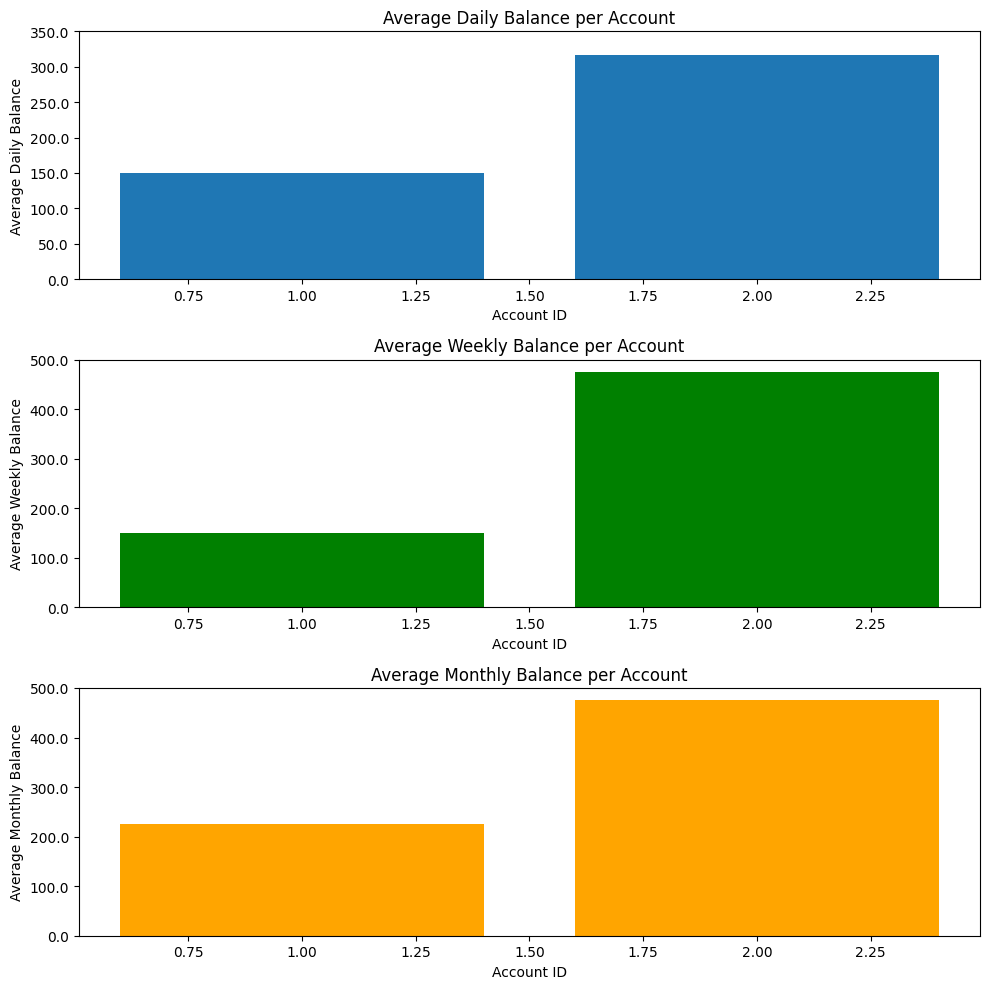

In [47]:
import matplotlib.pyplot as plt

# Assuming average_balances_df contains your actual data

# Plotting average daily, weekly, and monthly balances
plt.figure(figsize=(10, 10))  # Increased figure size for better visibility

# Average Daily Balance
plt.subplot(3, 1, 1)
plt.bar(average_balances_df['account_id'], average_balances_df['avg_daily_balance'])
plt.xlabel('Account ID')
plt.ylabel('Average Daily Balance')
plt.title('Average Daily Balance per Account')
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])  # Use existing ticks as labels for demonstration

# Average Weekly Balance
plt.subplot(3, 1, 2)
plt.bar(average_balances_df['account_id'], average_balances_df['avg_weekly_balance'], color='green')
plt.xlabel('Account ID')
plt.ylabel('Average Weekly Balance')
plt.title('Average Weekly Balance per Account')
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])  # Use existing ticks as labels for demonstration

# Average Monthly Balance
plt.subplot(3, 1, 3)
plt.bar(average_balances_df['account_id'], average_balances_df['avg_monthly_balance'], color='orange')
plt.xlabel('Account ID')
plt.ylabel('Average Monthly Balance')
plt.title('Average Monthly Balance per Account')
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])  # Use existing ticks as labels for demonstration

plt.tight_layout()
plt.show()


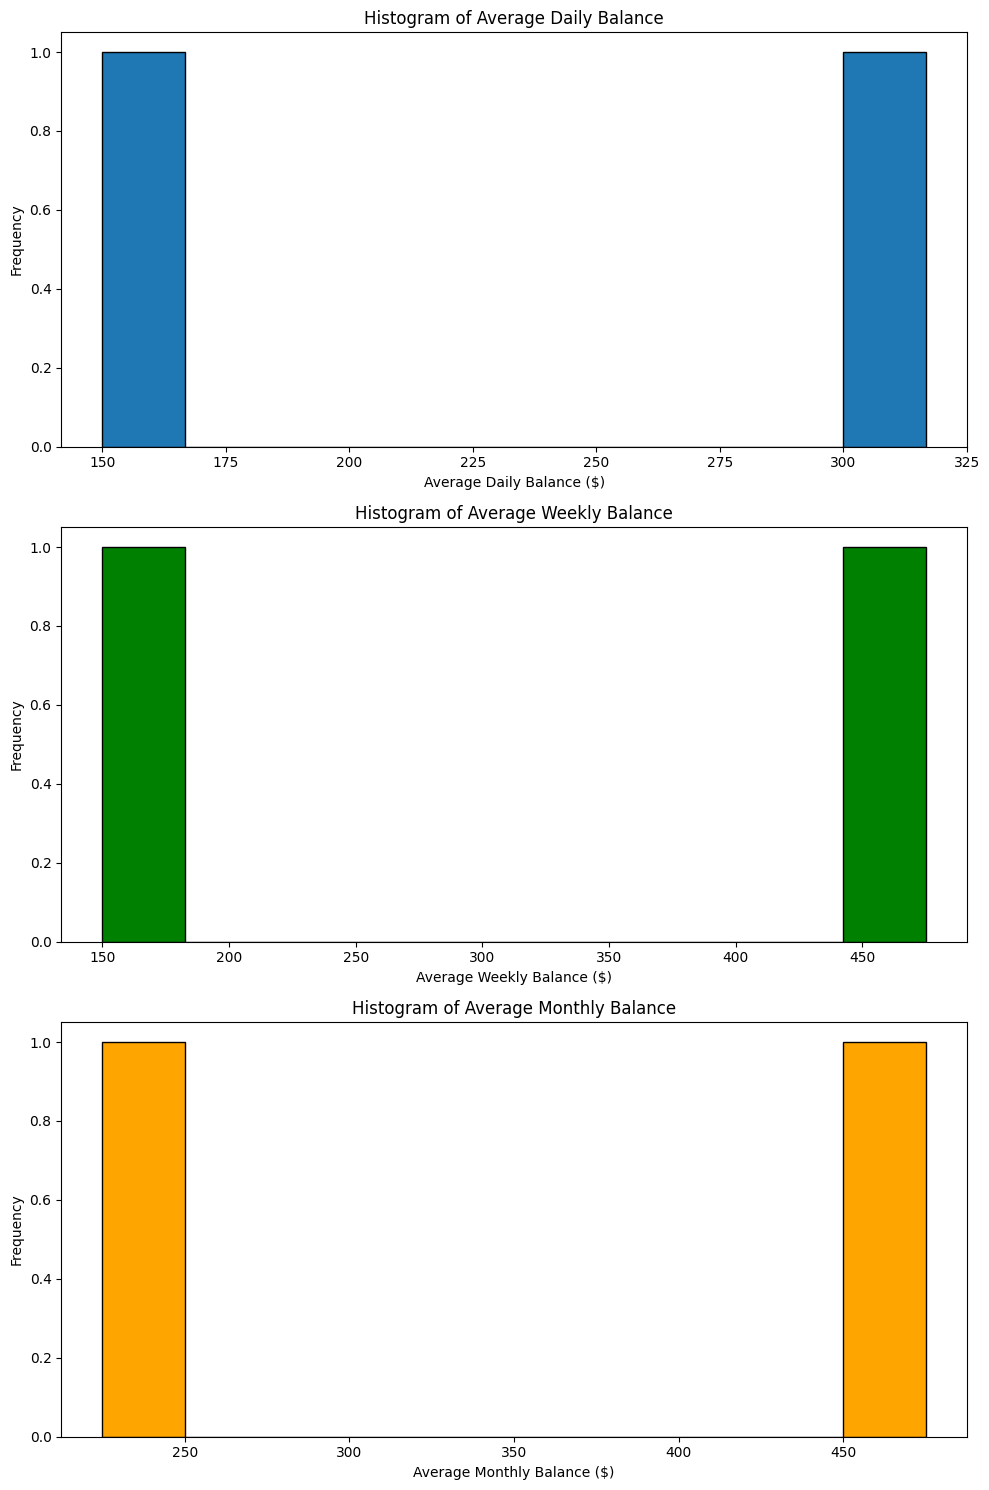

In [48]:
import matplotlib.pyplot as plt

# Assuming average_balances_df contains your actual data
# Replace the example data with your actual DataFrame
# average_balances_df.head()

# Plotting histogram for average balances
plt.figure(figsize=(10, 15))  # Adjust figure size as needed

# Histogram for Average Daily Balance
plt.subplot(3, 1, 1)
plt.hist(average_balances_df['avg_daily_balance'], bins=10, edgecolor='black')
plt.xlabel('Average Daily Balance ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Daily Balance')

# Histogram for Average Weekly Balance
plt.subplot(3, 1, 2)
plt.hist(average_balances_df['avg_weekly_balance'], bins=10, color='green', edgecolor='black')
plt.xlabel('Average Weekly Balance ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Weekly Balance')

# Histogram for Average Monthly Balance
plt.subplot(3, 1, 3)
plt.hist(average_balances_df['avg_monthly_balance'], bins=10, color='orange', edgecolor='black')
plt.xlabel('Average Monthly Balance ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Monthly Balance')

plt.tight_layout()
plt.show()


In [49]:
import pandas as pd

# Assuming average_balances_df contains your actual data

# Adding lagged features for daily, weekly, and monthly balances
lags = [1, 7, 30]  # Lags for 1 day, 1 week (7 days), and 1 month (30 days)

for lag in lags:
    # Lagged features for daily balance
    average_balances_df[f'avg_daily_balance_lag_{lag}'] = average_balances_df['avg_daily_balance'].shift(lag)
    
    # Lagged features for weekly balance
    average_balances_df[f'avg_weekly_balance_lag_{lag}'] = average_balances_df['avg_weekly_balance'].shift(lag)
    
    # Lagged features for monthly balance
    average_balances_df[f'avg_monthly_balance_lag_{lag}'] = average_balances_df['avg_monthly_balance'].shift(lag)

# Drop rows with NaN values
average_balances_df.dropna(inplace=True)

# Display the updated DataFrame without NaN values
print(average_balances_df.head())


Empty DataFrame
Columns: [account_id, avg_daily_balance, avg_weekly_balance, avg_monthly_balance, account_age_days, avg_daily_balance_lag_1, avg_weekly_balance_lag_1, avg_monthly_balance_lag_1, avg_daily_balance_lag_7, avg_weekly_balance_lag_7, avg_monthly_balance_lag_7, avg_daily_balance_lag_30, avg_weekly_balance_lag_30, avg_monthly_balance_lag_30]
Index: []


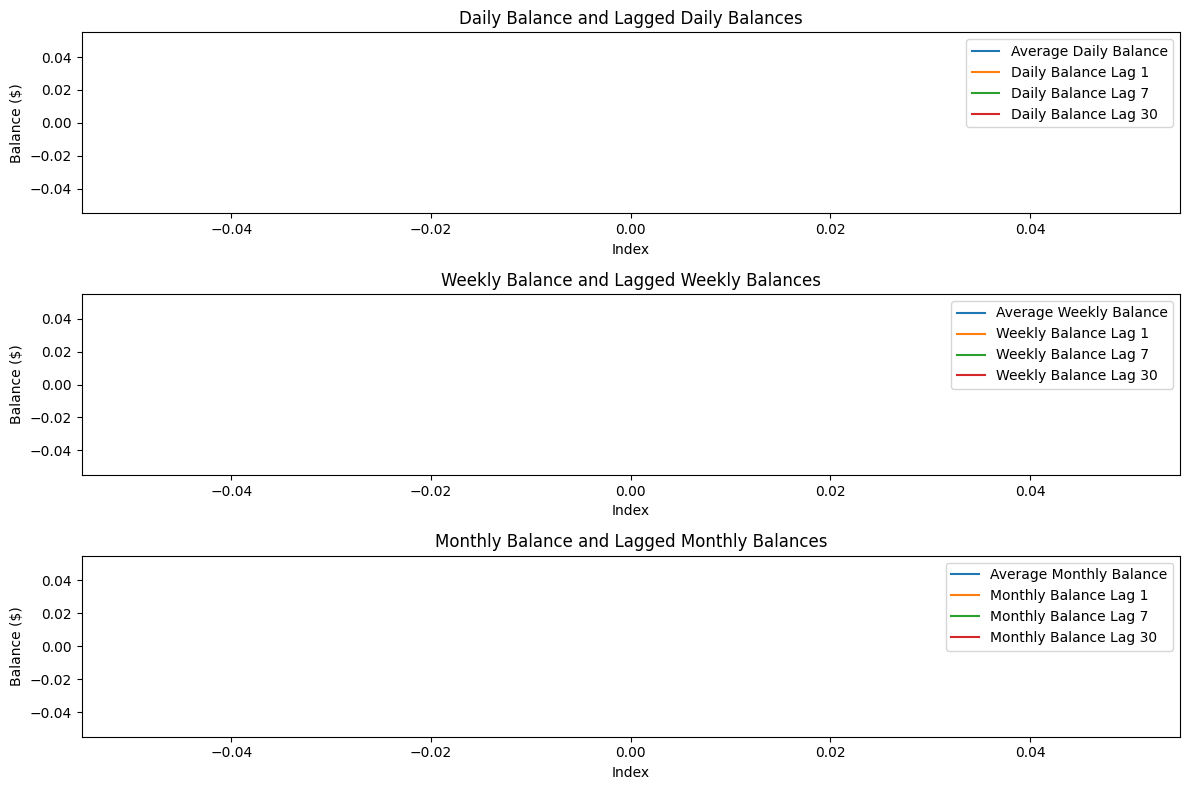

In [50]:
import matplotlib.pyplot as plt

# Assuming average_balances_df contains your actual data with lagged features

# Plotting original and lagged data
plt.figure(figsize=(12, 8))

# Plot for Average Daily Balance and Lagged Daily Balances
plt.subplot(3, 1, 1)
plt.plot(average_balances_df.index, average_balances_df['avg_daily_balance'], label='Average Daily Balance')
plt.plot(average_balances_df.index, average_balances_df['avg_daily_balance_lag_1'], label='Daily Balance Lag 1')
plt.plot(average_balances_df.index, average_balances_df['avg_daily_balance_lag_7'], label='Daily Balance Lag 7')
plt.plot(average_balances_df.index, average_balances_df['avg_daily_balance_lag_30'], label='Daily Balance Lag 30')
plt.xlabel('Index')
plt.ylabel('Balance ($)')
plt.title('Daily Balance and Lagged Daily Balances')
plt.legend()

# Plot for Average Weekly Balance and Lagged Weekly Balances
plt.subplot(3, 1, 2)
plt.plot(average_balances_df.index, average_balances_df['avg_weekly_balance'], label='Average Weekly Balance')
plt.plot(average_balances_df.index, average_balances_df['avg_weekly_balance_lag_1'], label='Weekly Balance Lag 1')
plt.plot(average_balances_df.index, average_balances_df['avg_weekly_balance_lag_7'], label='Weekly Balance Lag 7')
plt.plot(average_balances_df.index, average_balances_df['avg_weekly_balance_lag_30'], label='Weekly Balance Lag 30')
plt.xlabel('Index')
plt.ylabel('Balance ($)')
plt.title('Weekly Balance and Lagged Weekly Balances')
plt.legend()

# Plot for Average Monthly Balance and Lagged Monthly Balances
plt.subplot(3, 1, 3)
plt.plot(average_balances_df.index, average_balances_df['avg_monthly_balance'], label='Average Monthly Balance')
plt.plot(average_balances_df.index, average_balances_df['avg_monthly_balance_lag_1'], label='Monthly Balance Lag 1')
plt.plot(average_balances_df.index, average_balances_df['avg_monthly_balance_lag_7'], label='Monthly Balance Lag 7')
plt.plot(average_balances_df.index, average_balances_df['avg_monthly_balance_lag_30'], label='Monthly Balance Lag 30')
plt.xlabel('Index')
plt.ylabel('Balance ($)')
plt.title('Monthly Balance and Lagged Monthly Balances')
plt.legend()

plt.tight_layout()
plt.show()


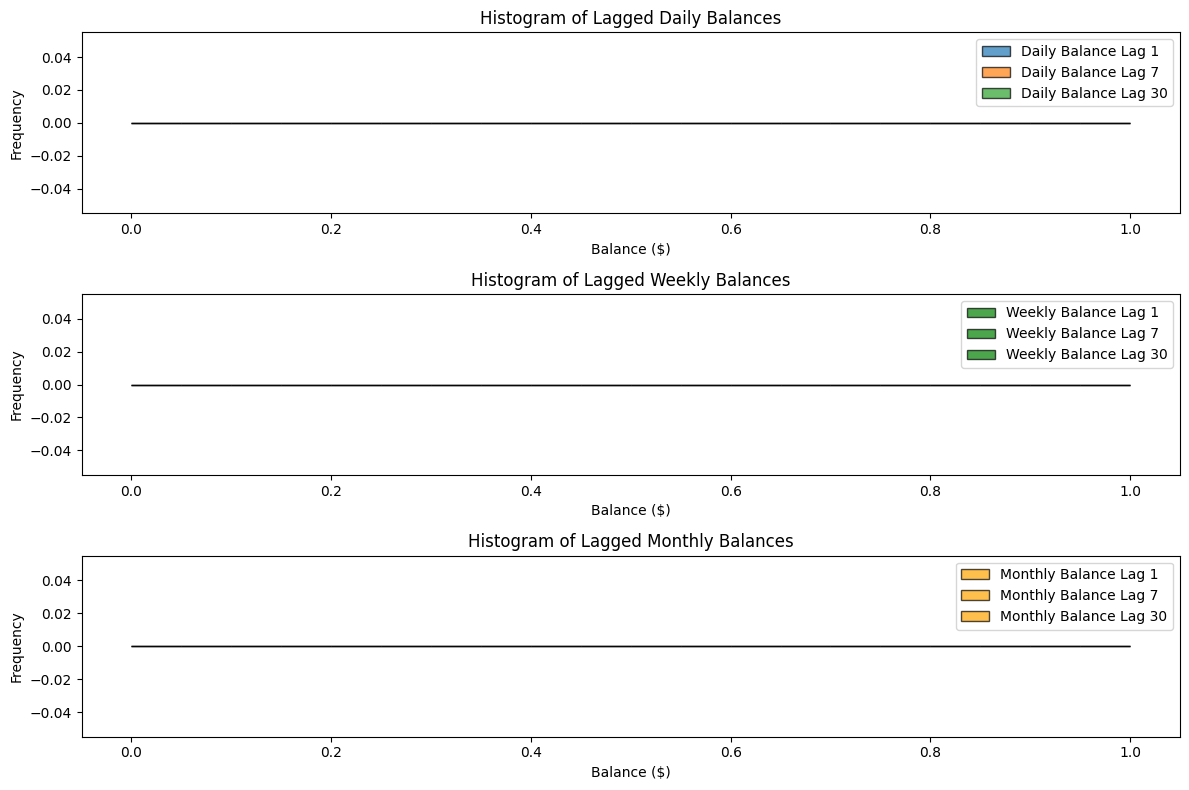

In [51]:
import matplotlib.pyplot as plt

# Assuming average_balances_df contains your actual data with lagged features

# Plotting histograms for lagged data
plt.figure(figsize=(12, 8))

# Histogram for Lagged Daily Balances
plt.subplot(3, 1, 1)
plt.hist(average_balances_df['avg_daily_balance_lag_1'].dropna(), bins=20, edgecolor='black', alpha=0.7, label='Daily Balance Lag 1')
plt.hist(average_balances_df['avg_daily_balance_lag_7'].dropna(), bins=20, edgecolor='black', alpha=0.7, label='Daily Balance Lag 7')
plt.hist(average_balances_df['avg_daily_balance_lag_30'].dropna(), bins=20, edgecolor='black', alpha=0.7, label='Daily Balance Lag 30')
plt.xlabel('Balance ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Lagged Daily Balances')
plt.legend()

# Histogram for Lagged Weekly Balances
plt.subplot(3, 1, 2)
plt.hist(average_balances_df['avg_weekly_balance_lag_1'].dropna(), bins=20, color='green', edgecolor='black', alpha=0.7, label='Weekly Balance Lag 1')
plt.hist(average_balances_df['avg_weekly_balance_lag_7'].dropna(), bins=20, color='green', edgecolor='black', alpha=0.7, label='Weekly Balance Lag 7')
plt.hist(average_balances_df['avg_weekly_balance_lag_30'].dropna(), bins=20, color='green', edgecolor='black', alpha=0.7, label='Weekly Balance Lag 30')
plt.xlabel('Balance ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Lagged Weekly Balances')
plt.legend()

# Histogram for Lagged Monthly Balances
plt.subplot(3, 1, 3)
plt.hist(average_balances_df['avg_monthly_balance_lag_1'].dropna(), bins=20, color='orange', edgecolor='black', alpha=0.7, label='Monthly Balance Lag 1')
plt.hist(average_balances_df['avg_monthly_balance_lag_7'].dropna(), bins=20, color='orange', edgecolor='black', alpha=0.7, label='Monthly Balance Lag 7')
plt.hist(average_balances_df['avg_monthly_balance_lag_30'].dropna(), bins=20, color='orange', edgecolor='black', alpha=0.7, label='Monthly Balance Lag 30')
plt.xlabel('Balance ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Lagged Monthly Balances')
plt.legend()

plt.tight_layout()
plt.show()


# Calculation of Average Balances and Lagged Time Features

In this notebook, we'll calculate average daily, weekly, and monthly balances, and then proceed to calculate their lagged features.

## 1. Calculation of Average Balances

### Daily Balance Calculation

The average daily balance ($\text{avg_daily_balance}[i]$) is calculated as:

$$
\text{avg_daily_balance}[i] = \frac{\sum_{j=i-29}^{i}{\text{f0_[j]}}}{30}
$$

Where:
- $\text{f0_[j]}$ is the daily transaction amount at index $j$.
- The sum is taken over the previous 30 days to compute the average daily balance.

### Weekly Balance Calculation

The average weekly balance ($\text{avg_weekly_balance}[i]$) is calculated as:

$$
\text{avg_weekly_balance}[i] = \frac{\sum_{j=i-6 \times 7}^{i}{\text{f0_[j]}}}{7}
$$

Where:
- $\text{f0_[j]}$ is the daily transaction amount at index $j$.
- The sum is taken over the previous 7 days (1 week) to compute the average weekly balance.

### Monthly Balance Calculation

The average monthly balance ($\text{avg_monthly_balance}[i]$) is calculated as:

$$
\text{avg_monthly_balance}[i] = \frac{\sum_{j=i-29 \times 30}^{i}{\text{f0_[j]}}}{30}
$$

Where:
- $\text{f0_[j]}$ is the daily transaction amount at index $j$.
- The sum is taken over the previous 30 days (1 month) to compute the average monthly balance.

## 2. Calculation of Lagged Time Features

### Daily Balance Lag Features

The lagged feature for daily balances ($\text{avg_daily_balance_lag}_{\text{lag}}[i]$) is calculated using the formula:

$$
\text{avg_daily_balance_lag}_{\text{lag}}[i] = \text{avg_daily_balance}[i - \text{lag}]
$$

Where:
- $\text{avg_daily_balance}[i]$ is the average daily balance at index $i$.
- $\text{lag}$ is the lag period in days.

### Weekly Balance Lag Features

The lagged feature for weekly balances ($\text{avg_weekly_balance\_lag}_{\text{lag}}[i]$) is calculated as:

$$
\text{avg_weekly_balance_lag}_{\text{lag}}[i] = \text{avg_weekly_balance}[i - 7 \times \text{lag}]
$$

Where:
- $\text{avg_weekly_balance}[i]$ is the average weekly balance at index $i$.
- $\text{lag}$ is the lag period in weeks.

### Monthly Balance Lag Features

The lagged feature for monthly balances ($\text{avg\_monthly_balance_lag}_{\text{lag}}[i]$) is calculated as:

$$
\text{avg_monthly_balance_lag}_{\text{lag}}[i] = \text{avg_monthly_balance}[i - 30 \times \text{lag}]
$$

Where:
- $\text{avg\_monthly\_balance}[i]$ is the average monthly balance at index $i$.
- $\text{lag}$ is the lag period in months.


In [41]:
 import pandas as pd

average_balances_df = pd.DataFrame({
    'account_id': [1, 2, 3, 4],
    'avg_daily_balance': [100, 150, 120, 200],
    'avg_weekly_balance': [700, 850, 840, 900],
    'avg_monthly_balance': [3000, 3500, 3200, 4000]
})

# Step 1: Calculate the reference date (earliest transaction date) for each account
account_min_dates = cleaned_data.groupby('account_id')['date'].min().reset_index()
account_min_dates.rename(columns={'date': 'account_open_date'}, inplace=True)

# Step 2: Merge with average_balances_df to add account_age
average_balances_df = pd.merge(average_balances_df, account_min_dates, on='account_id', how='left')

# Step 3: Calculate account_age as the difference between date and account_open_date
average_balances_df['account_age_days'] = (pd.Timestamp.now() - average_balances_df['account_open_date']).dt.days

# Optionally drop intermediate columns
average_balances_df.drop(['account_open_date'], axis=1, inplace=True)

# Display the updated DataFrame with account_age feature
print(average_balances_df.head())


   account_id  avg_daily_balance  avg_weekly_balance  avg_monthly_balance  \
0           1                100                 700                 3000   
1           2                150                 850                 3500   
2           3                120                 840                 3200   
3           4                200                 900                 4000   

   account_age_days  
0               570  
1               939  
2               946  
3               656  


# Now, applying machine learning:


## Best mehods i'd use here: gradient boosting or random forest.

random forest: If we seek a robust model that is less prone to overfitting and provides insights into feature importance.

Gradient boosting: If we prioritize predictive accuracy and have sufficient computational resources for training.

Discuss: Precision vs recall.

# 1. Define targets:

In [21]:
"""Feature Selection: Use age_of_account_days, avg_monthly_balance, and avg_weekly_balance as your input features (X).
Target Variable: Define a target variable (y) that indicates loan approval (1) or rejection (0) based on some criteria or historical data.
"""

# Example: Define loan eligibility based on a condition
your_data['loan_eligibility'] = your_data['loan_approval_status'].apply(lambda x: 1 if x == 'Approved' else 0)

# Now your_data should contain the 'loan_eligibility' column as the target variable


Empty DataFrame
Columns: [account_id, age_of_account_days, avg_monthly_balance, avg_weekly_balance, avg_daily_balance, avg_monthly_balance_lag1, avg_weekly_balance_lag1, loan_approval]
Index: []


In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and Target variable (y)
X = result[['age_of_account_days', 'avg_monthly_balance', 'avg_weekly_balance']]
y = result['loan_approval']  # Define loan_approval based on your criteria

# Split data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
